# Set up

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random
from joblib import Parallel, delayed
import os

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

# ElasticNet Analysis Function

In [ ]:
def regress_out_covariates(data, covariates, categorical_cols=None):
    """
    Regress out covariates from data using vectorized operations.
    Handles categorical variables by treating them as dummy variables.
    
    Parameters:
    data: DataFrame or array - the data to regress covariates from
    covariates: DataFrame - the covariate data
    categorical_cols: list - explicit list of column names to treat as categorical
    
    Returns:
    residuals: DataFrame or array - data with covariates regressed out
    """
    # Convert to numpy arrays for computation
    Y = np.array(data, dtype=float)
    
    # Handle categorical variables if DataFrame is passed
    if isinstance(covariates, pd.DataFrame):
        if categorical_cols is not None:
            # Explicitly specify which columns are categorical
            X_cov = pd.get_dummies(covariates, columns=categorical_cols, drop_first=True, dtype=float).values
        else:
            # Auto-detect categorical columns (object/string types)
            X_cov = pd.get_dummies(covariates, drop_first=True, dtype=float).values
    else:
        X_cov = np.array(covariates, dtype=float)
    
    # Add intercept column
    design_matrix = np.column_stack([np.ones(X_cov.shape[0]), X_cov])
    
    # Vectorized regression: solve for all columns simultaneously
    beta_coeffs = np.linalg.lstsq(design_matrix, Y, rcond=None)[0]
    
    # Calculate predictions and residuals
    predicted = design_matrix @ beta_coeffs
    residuals = Y - predicted
    
    # Return as DataFrame if input was DataFrame
    if isinstance(data, pd.DataFrame):
        return pd.DataFrame(residuals, index=data.index, columns=data.columns)
    else:
        return residuals
    

def elasticnet_covariate_regression(X, y, brain_regions, X_covariates, y_covariates, 
                                                 categorical_cols=None, n_splits=10, weights_dir=None, data_name=None, target_name=None):
    """
    ElasticNet analysis with demographic covariates regressed out beforehand.
    """
    # Separate demographic and brain region data
    X_demographic = X[X_covariates]
    y_demographic = X[y_covariates]
    X_brain = X[brain_regions]
    
    # Determine which covariates are categorical
    X_categorical = [col for col in X_covariates if col in (categorical_cols or [])]
    y_categorical = [col for col in y_covariates if col in (categorical_cols or [])]
    
    # Regress out demographic variables from brain regions
    print("Regressing out demographic variables from brain regions...")
    X_brain_residuals = regress_out_covariates(X_brain, X_demographic, X_categorical)
    
    # Regress out demographic variables from target variable
    print("Regressing out demographic variables from target variable...")
    y_residuals = regress_out_covariates(y, y_demographic, y_categorical)
    
    # Use only the residualized brain regions as features
    X_final = X_brain_residuals
    y_final = y_residuals.squeeze() if y_residuals.ndim > 1 else y_residuals
    
    # Simple preprocessing (just scaling, no categorical encoding needed)
    scaler = StandardScaler()
    
    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_params_per_fold = []
    nonzero_predictors = []
    coefs_list = []
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_final, y_final), start=1):
        X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
        
        # Handle y_final indexing based on its type
        if isinstance(y_final, pd.DataFrame) or isinstance(y_final, pd.Series):
            y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]
        else:
            # y_final is a numpy array
            y_train, y_test = y_final[train_idx], y_final[test_idx]
        
        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Inner CV
        elastic_net = ElasticNetCV(
            l1_ratio=np.linspace(0.3, 0.9, 7),
            alphas=np.logspace(-4, 1, 15),
            cv=10, max_iter=25000, random_state=42,
            n_jobs=-1
        )
        
        elastic_net.fit(X_train_scaled, y_train)
        y_pred = elastic_net.predict(X_test_scaled)
        
        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)
        
        # --- store best α & l1_ratio for this fold ---
        best_params_per_fold.append(
            {'alpha': elastic_net.alpha_, 'l1_ratio': elastic_net.l1_ratio_}
        )
        
        # --- predictors that survived ---
        coefs = elastic_net.coef_
        coefs_list.append(coefs)
        surviving = [col for col, c in zip(X_final.columns, coefs) if c != 0]
        nonzero_predictors.append(surviving)
        
        print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
              f'• α={elastic_net.alpha_:.4g} • l1_ratio={elastic_net.l1_ratio_:.2f}')
    
    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
    print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')
    
    # Calculate mean best parameters from all folds
    mean_alpha = np.mean([p['alpha'] for p in best_params_per_fold])
    mean_l1_ratio = np.mean([p['l1_ratio'] for p in best_params_per_fold])
    
    # Fit final model on all data
    final_scaler = StandardScaler()
    X_final_scaled = final_scaler.fit_transform(X_final)
    
    final_model = ElasticNet(
        alpha=mean_alpha,
        l1_ratio=mean_l1_ratio,
        max_iter=40000,
        random_state=42
    )
    
    final_model.fit(X_final_scaled, y_final)
    
    # Create coefficients DataFrame
    coefs_df = pd.DataFrame({
        'Feature': X_final.columns,
        'Coefficient': final_model.coef_
    })
    
    # Save coefficients
    os.makedirs(weights_dir, exist_ok=True)
    weights_filename = f'ElasticNet_weights_{data_name}_{target_name}.csv'
    weights_filepath = os.path.join(weights_dir, weights_filename)
    coefs_df.to_csv(weights_filepath, index=False)
    
    print(f"\nElasticNet coefficients saved to: {weights_filepath}")
    print(f"Final model parameters: α={mean_alpha:.4g}, l1_ratio={mean_l1_ratio:.3f}")
    print(f"Number of non-zero coefficients: {np.sum(final_model.coef_ != 0)}")
    
    return {
        'mae': outer_mae,
        'rmse': outer_rmse,
        'r2': outer_r2,
        'best_params': best_params_per_fold,
        'nonzero_predictors': nonzero_predictors,
        'coefficients': coefs_list
    }

# GF

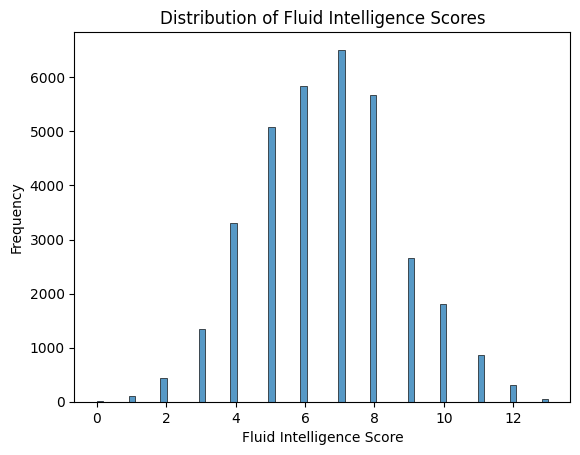

33977
(33977, 2628)


In [5]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_GF_no_outliers.csv', index_col=0)

# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

## GF vs. MIND (avg)

In [6]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (33977, 71), y: (33977,)


In [7]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • MAE=1.621 • RMSE=2.021 • R²=0.018 • α=0.01389 • l1_ratio=0.40
Fold 02 • MAE=1.635 • RMSE=2.034 • R²=0.016 • α=0.01389 • l1_ratio=0.30
Fold 03 • MAE=1.642 • RMSE=2.044 • R²=0.027 • α=0.01389 • l1_ratio=0.40
Fold 04 • MAE=1.652 • RMSE=2.058 • R²=0.018 • α=0.01389 • l1_ratio=0.30
Fold 05 • MAE=1.604 • RMSE=2.001 • R²=0.013 • α=0.01389 • l1_ratio=0.40
Fold 06 • MAE=1.584 • RMSE=1.975 • R²=0.022 • α=0.01389 • l1_ratio=0.30
Fold 07 • MAE=1.617 • RMSE=2.016 • R²=0.026 • α=0.01389 • l1_ratio=0.40
Fold 08 • MAE=1.657 • RMSE=2.052 • R²=0.010 • α=0.01389 • l1_ratio=0.30
Fold 09 • MAE=1.608 • RMSE=2.001 • R²=0.021 • α=0.01389 • l1_ratio=0.30
Fold 10 • MAE=1.629 • RMSE=2.033 • R²=0.020 • α=0.01389 • l1_ratio=0.30

=== 10-fold CV summary ===
Mean MAE :  1.625  ± 0.022
Mean RMSE:  2.024 ± 0.024
Mean R²  :  0.019  ± 0.005


## GF vs. MIND

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (33977, 2281), y: (33977,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=05 • MAE=1.603 • RMSE=2.002 • R²=0.036


## GF vs. CT

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(33977, 65)
(33977,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=06 • MAE=1.632 • RMSE=2.032 • R²=0.018
Fold 02 • n_comp=05 • MAE=1.644 • RMSE=2.042 • R²=0.024
Fold 03 • n_comp=09 • MAE=1.651 • RMSE=2.057 • R²=0.026
Fold 04 • n_comp=05 • MAE=1.662 • RMSE=2.070 • R²=0.021
Fold 05 • n_comp=05 • MAE=1.604 • RMSE=2.002 • R²=0.032
Fold 06 • n_comp=05 • MAE=1.589 • RMSE=1.985 • R²=0.035
Fold 07 • n_comp=06 • MAE=1.631 • RMSE=2.035 • R²=0.015
Fold 08 • n_comp=08 • MAE=1.652 • RMSE=2.046 • R²=0.028
Fold 09 • n_comp=09 • MAE=1.623 • RMSE=2.016 • R²=0.022
Fold 10 • n_comp=06 • MAE=1.637 • RMSE=2.043 • R²=0.026

=== 10-fold CV summary ===
n_components (mean ± std): 6.4 ± 1.6
MAE :  1.632 ± 0.021
RMSE:  2.033 ± 0.024
R²  :  0.025 ± 0.006


## GF vs. FC

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(33977, 214)
(33977,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 01 • n_comp=05 • MAE=1.581 • RMSE=1.985 • R²=0.063
Fold 02 • n_comp=05 • MAE=1.599 • RMSE=1.990 • R²=0.073
Fold 03 • n_comp=05 • MAE=1.615 • RMSE=2.020 • R²=0.060
Fold 04 • n_comp=05 • MAE=1.615 • RMSE=2.018 • R²=0.070
Fold 05 • n_comp=05 • MAE=1.573 • RMSE=1.964 • R²=0.068
Fold 06 • n_comp=05 • MAE=1.545 • RMSE=1.929 • R²=0.088
Fold 07 • n_comp=05 • MAE=1.598 • RMSE=1.995 • R²=0.053
Fold 08 • n_comp=05 • MAE=1.604 • RMSE=2.000 • R²=0.071
Fold 09 • n_comp=05 • MAE=1.572 • RMSE=1.965 • R²=0.070
Fold 10 • n_comp=05 • MAE=1.590 • RMSE=1.987 • R²=0.079

=== 10-fold CV summary ===
n_components (mean ± std): 5.0 ± 0.0
MAE :  1.589 ± 0.021
RMSE:  1.985 ± 0.026
R²  :  0.070 ± 0.009


# PAL

In [ ]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_PAL_no_outliers.csv', index_col=0)

# Histogram of PAL Scores
sns.histplot(df['20197-2.0'])
plt.title('Distribution of PAL Scores')
plt.xlabel('PAL Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

### PAL vs. MIND (avg)

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 71)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=05 • MAE=2.076 • RMSE=2.539 • R²=0.064
Fold 02 • n_comp=05 • MAE=2.104 • RMSE=2.551 • R²=0.046
Fold 03 • n_comp=05 • MAE=2.098 • RMSE=2.584 • R²=0.062
Fold 04 • n_comp=04 • MAE=2.071 • RMSE=2.533 • R²=0.059
Fold 05 • n_comp=05 • MAE=2.040 • RMSE=2.476 • R²=0.053
Fold 06 • n_comp=04 • MAE=2.105 • RMSE=2.559 • R²=0.081
Fold 07 • n_comp=05 • MAE=2.089 • RMSE=2.538 • R²=0.062
Fold 08 • n_comp=05 • MAE=2.068 • RMSE=2.536 • R²=0.065
Fold 09 • n_comp=05 • MAE=2.082 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.070 • RMSE=2.542 • R²=0.047

=== 10-fold CV summary ===
n_components (mean ± std): 4.8 ± 0.4
MAE :  2.080 ± 0.019
RMSE:  2.541 ± 0.026
R²  :  0.061 ± 0.009


### PAL vs. MIND

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 2281)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=07 • MAE=2.088 • RMSE=2.558 • R²=0.050
Fold 02 • n_comp=07 • MAE=2.105 • RMSE=2.551 • R²=0.046
Fold 03 • n_comp=07 • MAE=2.105 • RMSE=2.589 • R²=0.058
Fold 04 • n_comp=09 • MAE=2.091 • RMSE=2.564 • R²=0.036
Fold 05 • n_comp=07 • MAE=2.061 • RMSE=2.501 • R²=0.035
Fold 06 • n_comp=06 • MAE=2.129 • RMSE=2.598 • R²=0.052
Fold 07 • n_comp=08 • MAE=2.113 • RMSE=2.576 • R²=0.034
Fold 08 • n_comp=06 • MAE=2.085 • RMSE=2.557 • R²=0.049
Fold 09 • n_comp=09 • MAE=2.092 • RMSE=2.571 • R²=0.054
Fold 10 • n_comp=06 • MAE=2.088 • RMSE=2.559 • R²=0.035

=== 10-fold CV summary ===
n_components (mean ± std): 7.2 ± 1.1
MAE :  2.096 ± 0.018
RMSE:  2.562 ± 0.025
R²  :  0.045 ± 0.009


### PAL vs. CT

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 65)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=05 • MAE=2.081 • RMSE=2.537 • R²=0.066
Fold 02 • n_comp=05 • MAE=2.106 • RMSE=2.556 • R²=0.043
Fold 03 • n_comp=05 • MAE=2.096 • RMSE=2.581 • R²=0.064
Fold 04 • n_comp=05 • MAE=2.065 • RMSE=2.532 • R²=0.060
Fold 05 • n_comp=05 • MAE=2.041 • RMSE=2.475 • R²=0.055
Fold 06 • n_comp=06 • MAE=2.107 • RMSE=2.564 • R²=0.077
Fold 07 • n_comp=05 • MAE=2.087 • RMSE=2.537 • R²=0.063
Fold 08 • n_comp=05 • MAE=2.073 • RMSE=2.540 • R²=0.061
Fold 09 • n_comp=05 • MAE=2.084 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.076 • RMSE=2.542 • R²=0.048

=== 10-fold CV summary ===
n_components (mean ± std): 5.1 ± 0.3
MAE :  2.082 ± 0.019
RMSE:  2.542 ± 0.027
R²  :  0.060 ± 0.009


### PAL vs. FC

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 214)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=09 • MAE=2.035 • RMSE=2.503 • R²=0.091
Fold 02 • n_comp=10 • MAE=2.039 • RMSE=2.497 • R²=0.087
Fold 03 • n_comp=09 • MAE=2.055 • RMSE=2.543 • R²=0.091
Fold 04 • n_comp=09 • MAE=2.035 • RMSE=2.496 • R²=0.087
Fold 05 • n_comp=10 • MAE=1.994 • RMSE=2.423 • R²=0.093
Fold 06 • n_comp=09 • MAE=2.053 • RMSE=2.523 • R²=0.106
Fold 07 • n_comp=10 • MAE=2.031 • RMSE=2.487 • R²=0.099
Fold 08 • n_comp=09 • MAE=2.032 • RMSE=2.500 • R²=0.091
Fold 09 • n_comp=09 • MAE=2.037 • RMSE=2.515 • R²=0.094
Fold 10 • n_comp=10 • MAE=2.016 • RMSE=2.484 • R²=0.091

=== 10-fold CV summary ===
n_components (mean ± std): 9.4 ± 0.5
MAE :  2.033 ± 0.017
RMSE:  2.497 ± 0.030
R²  :  0.093 ± 0.006


# DSST

In [ ]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_DSST_no_outliers.csv', index_col=0)

# Histogram of DSST Scores
sns.histplot(df['23324-2.0'])
plt.title('Distribution of DSST Scores')
plt.xlabel('DSST Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

### DSST vs. MIND (avg)

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24275, 71)
(24275,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=05 • MAE=3.703 • RMSE=4.712 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.804 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=05 • MAE=3.725 • RMSE=4.712 • R²=0.200
Fold 04 • n_comp=06 • MAE=3.665 • RMSE=4.619 • R²=0.161
Fold 05 • n_comp=06 • MAE=3.782 • RMSE=4.816 • R²=0.181
Fold 06 • n_comp=06 • MAE=3.701 • RMSE=4.738 • R²=0.195
Fold 07 • n_comp=06 • MAE=3.738 • RMSE=4.754 • R²=0.188
Fold 08 • n_comp=06 • MAE=3.713 • RMSE=4.738 • R²=0.184
Fold 09 • n_comp=06 • MAE=3.640 • RMSE=4.636 • R²=0.189
Fold 10 • n_comp=06 • MAE=3.650 • RMSE=4.597 • R²=0.203

=== 10-fold CV summary ===
n_components (mean ± std): 5.8 ± 0.4
MAE :  3.712 ± 0.050
RMSE:  4.717 ± 0.077
R²  :  0.190 ± 0.013


### DSST vs. MIND

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24275, 2281)
(24275,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=10 • MAE=3.764 • RMSE=4.769 • R²=0.173
Fold 02 • n_comp=10 • MAE=3.865 • RMSE=4.909 • R²=0.186
Fold 03 • n_comp=10 • MAE=3.760 • RMSE=4.766 • R²=0.181
Fold 04 • n_comp=10 • MAE=3.686 • RMSE=4.673 • R²=0.141
Fold 05 • n_comp=10 • MAE=3.821 • RMSE=4.863 • R²=0.165
Fold 06 • n_comp=10 • MAE=3.772 • RMSE=4.812 • R²=0.170
Fold 07 • n_comp=10 • MAE=3.816 • RMSE=4.831 • R²=0.162
Fold 08 • n_comp=10 • MAE=3.761 • RMSE=4.808 • R²=0.159
Fold 09 • n_comp=10 • MAE=3.675 • RMSE=4.670 • R²=0.178
Fold 10 • n_comp=10 • MAE=3.686 • RMSE=4.649 • R²=0.185

=== 10-fold CV summary ===
n_components (mean ± std): 10.0 ± 0.0
MAE :  3.761 ± 0.060
RMSE:  4.775 ± 0.083
R²  :  0.170 ± 0.013


### DSST vs. CT

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24275, 65)
(24275,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=06 • MAE=3.709 • RMSE=4.711 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.811 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=06 • MAE=3.715 • RMSE=4.713 • R²=0.199
Fold 04 • n_comp=06 • MAE=3.659 • RMSE=4.612 • R²=0.163
Fold 05 • n_comp=06 • MAE=3.789 • RMSE=4.831 • R²=0.176
Fold 06 • n_comp=06 • MAE=3.700 • RMSE=4.728 • R²=0.198
Fold 07 • n_comp=06 • MAE=3.743 • RMSE=4.774 • R²=0.181
Fold 08 • n_comp=06 • MAE=3.722 • RMSE=4.751 • R²=0.179
Fold 09 • n_comp=06 • MAE=3.643 • RMSE=4.639 • R²=0.188
Fold 10 • n_comp=06 • MAE=3.652 • RMSE=4.610 • R²=0.198

=== 10-fold CV summary ===
n_components (mean ± std): 6.0 ± 0.0
MAE :  3.714 ± 0.053
RMSE:  4.721 ± 0.079
R²  :  0.188 ± 0.013


### DSST vs. FC

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24275, 214)
(24275,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=09 • MAE=3.647 • RMSE=4.658 • R²=0.211
Fold 02 • n_comp=09 • MAE=3.773 • RMSE=4.814 • R²=0.217
Fold 03 • n_comp=09 • MAE=3.699 • RMSE=4.674 • R²=0.213
Fold 04 • n_comp=09 • MAE=3.648 • RMSE=4.611 • R²=0.164
Fold 05 • n_comp=09 • MAE=3.779 • RMSE=4.796 • R²=0.188
Fold 06 • n_comp=09 • MAE=3.669 • RMSE=4.691 • R²=0.211
Fold 07 • n_comp=09 • MAE=3.714 • RMSE=4.719 • R²=0.200
Fold 08 • n_comp=10 • MAE=3.684 • RMSE=4.727 • R²=0.187
Fold 09 • n_comp=10 • MAE=3.633 • RMSE=4.616 • R²=0.196
Fold 10 • n_comp=09 • MAE=3.617 • RMSE=4.565 • R²=0.214

=== 10-fold CV summary ===
n_components (mean ± std): 9.2 ± 0.4
MAE :  3.686 ± 0.053
RMSE:  4.687 ± 0.076
R²  :  0.200 ± 0.016


# TMT

In [ ]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_TMT_no_outliers.csv', index_col=0)

# Histogram of TMT Scores
sns.histplot(df['trailmaking_score'])
plt.title('Distribution of TMT Scores')
plt.xlabel('TMT Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

### TMT vs. MIND (avg)

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 71)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=04 • MAE=176.425 • RMSE=293.983 • R²=0.082
Fold 02 • n_comp=04 • MAE=172.440 • RMSE=276.644 • R²=0.073
Fold 03 • n_comp=04 • MAE=177.297 • RMSE=279.430 • R²=0.063
Fold 04 • n_comp=04 • MAE=172.116 • RMSE=269.513 • R²=0.079
Fold 05 • n_comp=04 • MAE=171.227 • RMSE=265.072 • R²=0.044
Fold 06 • n_comp=04 • MAE=173.696 • RMSE=262.275 • R²=0.069
Fold 07 • n_comp=04 • MAE=176.838 • RMSE=262.683 • R²=0.056
Fold 08 • n_comp=04 • MAE=170.765 • RMSE=261.890 • R²=0.082
Fold 09 • n_comp=04 • MAE=172.606 • RMSE=276.270 • R²=0.066
Fold 10 • n_comp=04 • MAE=168.278 • RMSE=260.266 • R²=0.054

=== 10-fold CV summary ===
n_components (mean ± std): 4.0 ± 0.0
MAE :  173.169 ± 2.772
RMSE:  270.803 ± 10.195
R²  :  0.067 ± 0.012


### TMT vs. MIND

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 2281)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=06 • MAE=178.817 • RMSE=296.572 • R²=0.065
Fold 02 • n_comp=07 • MAE=176.302 • RMSE=280.124 • R²=0.049
Fold 03 • n_comp=07 • MAE=181.287 • RMSE=285.389 • R²=0.023
Fold 04 • n_comp=07 • MAE=175.723 • RMSE=273.635 • R²=0.051
Fold 05 • n_comp=06 • MAE=173.849 • RMSE=267.583 • R²=0.026
Fold 06 • n_comp=06 • MAE=176.252 • RMSE=263.684 • R²=0.059
Fold 07 • n_comp=06 • MAE=178.031 • RMSE=264.085 • R²=0.046
Fold 08 • n_comp=07 • MAE=175.083 • RMSE=265.310 • R²=0.058
Fold 09 • n_comp=05 • MAE=177.449 • RMSE=279.785 • R²=0.042
Fold 10 • n_comp=06 • MAE=171.326 • RMSE=263.140 • R²=0.033

=== 10-fold CV summary ===
n_components (mean ± std): 6.3 ± 0.6
MAE :  176.412 ± 2.607
RMSE:  273.931 ± 10.722
R²  :  0.045 ± 0.013


### TMT vs. CT

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 65)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=05 • MAE=176.795 • RMSE=294.811 • R²=0.076
Fold 02 • n_comp=05 • MAE=172.517 • RMSE=276.251 • R²=0.076
Fold 03 • n_comp=05 • MAE=177.328 • RMSE=279.850 • R²=0.060
Fold 04 • n_comp=05 • MAE=171.812 • RMSE=269.260 • R²=0.081
Fold 05 • n_comp=05 • MAE=171.478 • RMSE=265.403 • R²=0.042
Fold 06 • n_comp=05 • MAE=173.821 • RMSE=262.212 • R²=0.069
Fold 07 • n_comp=05 • MAE=176.760 • RMSE=262.482 • R²=0.057
Fold 08 • n_comp=05 • MAE=172.398 • RMSE=262.920 • R²=0.075
Fold 09 • n_comp=05 • MAE=173.251 • RMSE=276.179 • R²=0.067
Fold 10 • n_comp=05 • MAE=168.856 • RMSE=260.247 • R²=0.054

=== 10-fold CV summary ===
n_components (mean ± std): 5.0 ± 0.0
MAE :  173.502 ± 2.588
RMSE:  270.961 ± 10.319
R²  :  0.066 ± 0.012


### TMT vs. FC

In [ ]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

(24492, 214)
(24492,)


In [ ]:
# Run analysis with covariate regression
results = elasticnet_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Fold 01 • n_comp=09 • MAE=175.815 • RMSE=292.650 • R²=0.090
Fold 02 • n_comp=08 • MAE=172.804 • RMSE=277.529 • R²=0.067
Fold 03 • n_comp=09 • MAE=175.728 • RMSE=277.324 • R²=0.077
Fold 04 • n_comp=08 • MAE=172.391 • RMSE=269.491 • R²=0.080
Fold 05 • n_comp=08 • MAE=169.631 • RMSE=263.416 • R²=0.056
Fold 06 • n_comp=07 • MAE=172.061 • RMSE=260.911 • R²=0.079
Fold 07 • n_comp=08 • MAE=173.836 • RMSE=261.197 • R²=0.066
Fold 08 • n_comp=08 • MAE=170.318 • RMSE=261.209 • R²=0.087
Fold 09 • n_comp=09 • MAE=169.796 • RMSE=271.336 • R²=0.099
Fold 10 • n_comp=08 • MAE=167.751 • RMSE=258.536 • R²=0.067

=== 10-fold CV summary ===
n_components (mean ± std): 8.2 ± 0.6
MAE :  172.013 ± 2.529
RMSE:  269.360 ± 10.166
R²  :  0.077 ± 0.012
